# Initial Regression Analysis of House Prices

In this notebook we are interested in building a predictive regression model for house prices. Data describes the sales of individual residential properties in Ames, Iowa from 2006 to 2010. We will perform a very basic initial analysis and fit a linear predictive model to the observed data.

In [169]:
# note that the latest dev version of sklearn is used (because of CategoricalEncoder)
# install it with pip install git+https://github.com/scikit-learn/scikit-learn.git

import warnings
import matplotlib
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import norm, uniform, randint
from scipy.stats.mstats import mquantiles
from sklearn.dummy import DummyRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.feature_selection import VarianceThreshold, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import CategoricalEncoder, StandardScaler, Imputer, FunctionTransformer, PolynomialFeatures
from sklearn.utils import resample
from sklearn_pandas import DataFrameMapper, CategoricalImputer

%matplotlib inline
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
np.random.seed(0)

In [2]:
# load the data
X_tr = pd.read_csv('train.csv', index_col='Id')
X_te = pd.read_csv('test.csv', index_col='Id')

response_col_name = X_tr.columns[-1]
y_tr = X_tr[response_col_name]
X_tr.drop(response_col_name, axis=1, inplace=True)

print("train data dimensions: {}".format(X_tr.shape))
print("response column name and dimensions: {}, {}".format(response_col_name, y_tr.shape))
print("test data dimensions: {}".format(X_te.shape))
X_tr.head()

train data dimensions: (1460, 79)
response column name and dimensions: SalePrice, (1460,)
test data dimensions: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 1. Preprocessing
As a first step we will put the observed data into the form that is suitable for modelling. All of the transformations are going to be part of the learning process in order to avoid getting overconfident results (i.e. we'll use sklearn's Pipeline objects). First let's specify (based on *data_description.txt*) which features will be treated as categorical, ordinal, poisson and continuous. Unfortunately we have to do this manually.

In [3]:
categorical_cols = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'GarageType',
    'PavedDrive',
    'MiscFeature',
    'SaleType',
    'SaleCondition']

ordinal_cols = [
    'OverallQual',
    'OverallCond',
    'ExterQual',    # not encoded
    'ExterCond',    # not encoded
    'BsmtQual',     # not encoded
    'BsmtCond',     # not encoded
    'BsmtExposure', # not encoded
    'BsmtFinType1', # not encoded
    'BsmtFinType2', # not encoded
    'HeatingQC',    # not encoded
    'KitchenQual',  # not encoded
    'Functional',   # not encoded
    'FireplaceQu',  # not encoded
    'GarageFinish', # not encoded
    'GarageQual',   # not encoded
    'GarageCond',   # not encoded
    'PoolQC',       # not encoded
    'Fence',        # not encoded
    'MoSold']

poisson_cols = [
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars']

continuous_cols = [
    'LotFrontage',
    'LotArea',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'GarageYrBlt',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'YrSold']

len(categorical_cols + ordinal_cols + poisson_cols + continuous_cols)

79

### 1.1 Missing Values
Let's take a look at the fraction of missing values for each feature in the training and test sets.

In [4]:
def get_fraction_nan(df):
    fraction_nan = df.isnull().sum() / len(df)
    return fraction_nan[fraction_nan != 0].sort_values(ascending=False)

In [5]:
get_fraction_nan(X_tr)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [6]:
get_fraction_nan(X_te)

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageYrBlt     0.053461
GarageCond      0.053461
GarageQual      0.053461
GarageFinish    0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtQual        0.030158
BsmtFinType1    0.028787
BsmtFinType2    0.028787
MasVnrType      0.010966
MasVnrArea      0.010281
MSZoning        0.002742
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
Utilities       0.001371
Functional      0.001371
Exterior2nd     0.000685
Exterior1st     0.000685
SaleType        0.000685
BsmtFinSF1      0.000685
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
KitchenQual     0.000685
GarageCars      0.000685
GarageArea      0.000685
TotalBsmtSF     0.000685
dtype: float64

At first glance it seems that we are dealing with quite a lot of missing values, but as it turns out some of the NaNs actually provide meaningful info (see *data_description.txt*). E.g. NaN values in the *PoolQC* (pool quality) feature mean *no pool*, rather than *we don't know*.

We should be careful with true missing data however, e.g. we shouldn't impute mean value for *GarageYrBlt* if there is no garage, etc. Nevertheles, we won't spend time with this as part of the first solution, specially as there aren't a lot of problematic examples (e.g. see fractions for *GarageX* features above).

Let's fix the meaningful NaNs first.

In [7]:
not_nan_cols = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageQual',
    'GarageFinish',
    'GarageType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtQual',
    'BsmtFinType1',
    'BsmtFinType2']

X_tr[not_nan_cols] = X_tr[not_nan_cols].fillna('No')
X_te[not_nan_cols] = X_te[not_nan_cols].fillna('No')

In [8]:
get_fraction_nan(X_tr)

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
MasVnrType     0.005479
Electrical     0.000685
dtype: float64

In [9]:
get_fraction_nan(X_te)

LotFrontage     0.155586
GarageYrBlt     0.053461
MasVnrType      0.010966
MasVnrArea      0.010281
MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
BsmtHalfBath    0.001371
BsmtFullBath    0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
SaleType        0.000685
BsmtFinSF1      0.000685
BsmtFinSF2      0.000685
GarageArea      0.000685
TotalBsmtSF     0.000685
KitchenQual     0.000685
GarageCars      0.000685
BsmtUnfSF       0.000685
dtype: float64

In [10]:
def make_imputer():
    # most frequent imputer
    impute_most_frequent_cols = categorical_cols + ordinal_cols + poisson_cols
    most_frequent_imputer = [([col], CategoricalImputer()) for col in impute_most_frequent_cols]

    # mean imputer
    mean_imputer = [([col], Imputer(strategy='mean')) for col in continuous_cols]
    return DataFrameMapper(most_frequent_imputer + mean_imputer, df_out=True)

### 1.2 Encoding and Normalization
We will use dummy variables for categorical features. On the other hand, encoding ordinal variables is a more delicate matter. If we use ordinal encoding (e.g. 1, 2, ..., n), weights cannot encode an n-way choice. If we use one-hot encoding we discard the information about relative ordering of the choices. Again, for the purposes of simplicity of the first solution we will use dummy variables for ordinal features. We will use zero mean, unit variance normalization for continuous features. Count data should also be standardized, but let's take a look at the scales of all poisson features first.

In [11]:
X_tr[poisson_cols].describe().T[['min', 'max']]

,min,max
BsmtFullBath,0.0,3.0
BsmtHalfBath,0.0,2.0
FullBath,0.0,3.0
HalfBath,0.0,2.0
BedroomAbvGr,0.0,8.0
KitchenAbvGr,0.0,3.0
TotRmsAbvGrd,2.0,14.0
Fireplaces,0.0,3.0
GarageCars,0.0,4.0


For now we will normalize count data the same as continuous data, although we should come back to this later.

In [12]:
def make_encoder():
    # one-hot encoding
    encoder_params = {'encoding': 'onehot-dense', 'handle_unknown': 'ignore'}
    categorical_encoder = [([col], CategoricalEncoder(**encoder_params)) for col in categorical_cols + ordinal_cols]
    return DataFrameMapper(categorical_encoder, default=None, df_out=True)

def make_normalizer(df_out):
    # zero mean, unit variance
    unit_normal_standardizer = [([col], StandardScaler()) for col in continuous_cols + poisson_cols]
    return DataFrameMapper(unit_normal_standardizer, default=None, df_out=df_out)

In [13]:
# a function that initializes a new pipeline (unfitted objects)
def init_pipeline(*transformers, df_out=False):
    imputer = make_imputer()
    cat_encoder = make_encoder()
    normalizer = make_normalizer(df_out)
    return make_pipeline(imputer, cat_encoder, normalizer, *transformers)

In [14]:
# test the pipeline on train and test data
preprocess = init_pipeline(df_out=True)
X_tr_prep = preprocess.fit_transform(X_tr)

print("preprocessed train data dimensions: {}".format(X_tr_prep.shape))
X_tr_prep.head()

preprocessed train data dimensions: (1460, 343)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.229372,-0.207142,1.05099,0.878668,0.511418,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,0,0,0,0,0,0,0,0,0,0
2,0.451936,-0.0918864,0.156734,-0.429577,-0.57441,1.17199,-0.288653,-0.641228,0.466465,0.25714,...,0,0,1,0,0,0,0,0,0,0
3,-0.0931102,0.07348,0.984752,0.830215,0.32306,0.0929072,-0.288653,-0.301643,-0.313369,-0.627826,...,0,0,0,0,0,0,1,0,0,0
4,-0.456474,-0.0968975,-1.86363,-0.720298,-0.57441,-0.499274,-0.288653,-0.0616696,-0.687324,-0.521734,...,0,0,0,0,0,0,0,0,0,0
5,0.633618,0.375148,0.951632,0.733308,1.36457,0.463568,-0.288653,-0.174865,0.19968,-0.0456113,...,0,0,0,0,0,0,0,0,0,1


In [15]:
X_te_prep = preprocess.transform(X_te)
print("preprocessed test data dimensions: {}".format(X_te_prep.shape))
X_te_prep.head()

preprocessed test data dimensions: (1459, 343)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.451936,0.110763,-0.340077,-1.15638,-0.57441,0.0534285,0.604293,-0.672923,-0.400017,-0.689929,...,0,0,0,1,0,0,0,0,0,0
1462,0.497357,0.37585,-0.43944,-1.30174,0.0239034,1.05136,-0.288653,-0.365032,0.619239,0.430511,...,0,0,0,1,0,0,0,0,0,0
1463,0.179413,0.332053,0.852269,0.6364,-0.57441,0.761852,-0.288653,-0.974021,-0.295127,-0.607125,...,1,0,0,0,0,0,0,0,0,0
1464,0.361095,-0.0540024,0.88539,0.6364,-0.463612,0.347326,-0.288653,-0.550672,-0.299687,-0.6123,...,0,0,0,1,0,0,0,0,0,0
1465,-1.22862,-0.552407,0.686666,0.345679,-0.57441,-0.39619,-0.288653,1.01821,0.507509,0.303718,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# function to map transformed features back to human-readable names
# for easier interpretation
features_names_dict = {x[0][0]: x[1].categories_[0] for x in preprocess.steps[1][1].features}

def feature_name(feature_name):
    if '_' not in feature_name:
        return feature_name

    name, index = feature_name.split('_')
    return "{:s}_{}".format(name, features_names_dict[name][int(index)])

## 2. Exploratory Analysis
Let's perform some very basic EDA. We'll start with univariate feature analysis (estimate linear relationship by calculating each features' F score). Additionally, we will bootstrap standard errors and pragmatically estimate the score that could easily be obtained by chance (via a permutation test).

In [17]:
# permutaion test
f_scores = []
y_tr_permutated = np.copy(y_tr)

for _ in range(1000):
    np.random.shuffle(y_tr_permutated)
    f_score = f_regression(X_tr_prep, y_tr_permutated)
    f_scores += f_score[0].tolist()

f_score_chance = max(f_scores)
f_score_chance

64.14415614334128

In [18]:
# bootstrapping
f_scores = np.empty((0, X_tr_prep.shape[1]))

for _ in range(1000):
    X_sample, y_sample = resample(X_tr_prep, y_tr, replace=True)

    # remove warnings caused by constant features
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f_score = f_regression(X_sample, y_sample)
        f_scores = np.vstack((f_scores, f_score[0]))

# 95 percent confidence intervals
f_scores_se = mquantiles(f_scores, [.025, 0.5, .975], axis=0)

In [36]:
df = pd.DataFrame({
    'low': f_scores_se[0, :],
    'mean': f_scores_se[1, :],
    'high': f_scores_se[2, :],
    'feature': [feature_name(x) for x in X_tr_prep.columns],
    'feature_orig_name': X_tr_prep.columns})

# drop features that had zero variance
df = df.dropna()

ordered_cat = df.sort_values(by='mean', ascending=False)['feature']
df['feature'] = pd.Categorical(df['feature'], categories=ordered_cat, ordered=True)
df = df.sort_values(by='mean', ascending=False)

Now we can take a look at the number of features that are less correlated with the observed variable than could be by chance. Additionally, we will plot mean F scores along with standard errors for the best 20 features. When modelling, we could take advantage of all informative features (although we should keep in mind that uninformative could still be useful in combination with some other features).

In [37]:
df_worst = df[df['mean'] < f_score_chance]
print("number of features correlated less than by chance: {:d}".format(len(df_worst)))

number of features correlated less than by chance: 213


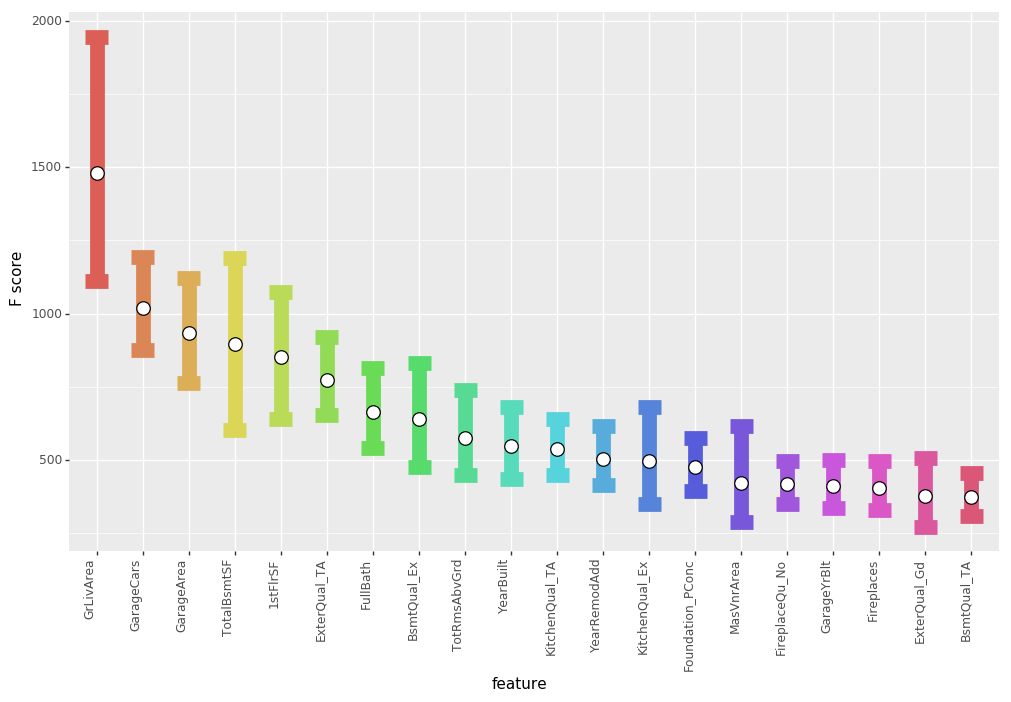

<ggplot: (292718249)>

In [38]:
df_top = df[df['mean'] > f_score_chance]
df_top_20 = df_top.head(20)
df_top_20['feature'].cat.remove_unused_categories(inplace=True)

# visualize some top features
(ggplot(df_top_20)
    + geom_errorbar(
        aes(x='feature',
            ymin='low',
            ymax='high',
            color='feature',
            size=1),
        show_legend=False)
    + geom_point(aes(x='feature', y='mean'), size=5, fill='white')
    + labs(x='feature', y='F score')
    + theme(axis_text_x=element_text(angle=90, hjust=1), figure_size=(12, 7)))

## 3. Modelling

### 3.1 Linear Relationships
We will use linear regression as our first model. Let's first check if any of the assumptions we make about the underlying data (by selecting this particular parametric model) are violated. For now we won't care how much we (over)fit to the data, we are only using certain diagnostics to check whether our model is able to capture the given information. There are many assumptions that should be checked, but for now we will only inspect the normality of residuals.

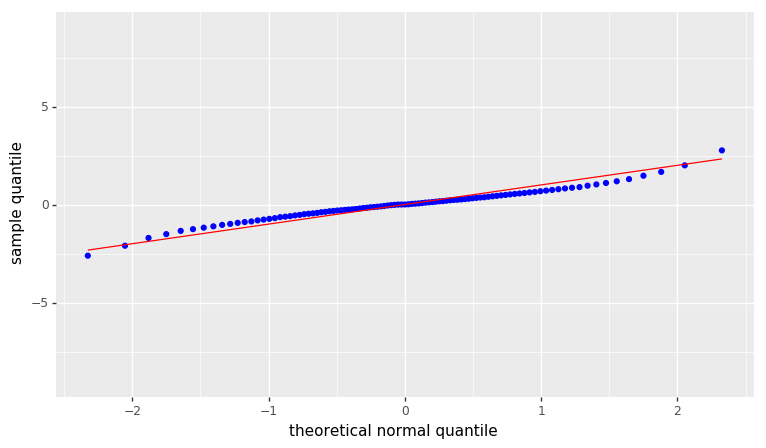

<ggplot: (-9223372036556546858)>

In [23]:
lin_reg = LinearRegression()
pipeline = init_pipeline(lin_reg)

pipeline.fit(X_tr, y_tr)
y_tr_pred = pipeline.predict(X_tr)

residuals = y_tr - y_tr_pred
residuals = (residuals - residuals.mean()) / residuals.std()

qs = np.arange(0, 1.01, .01)
theoretical_quantiles = norm.ppf(qs)
sample_quantiles = mquantiles(residuals, qs)

df = pd.DataFrame({'x': theoretical_quantiles, 'y': sample_quantiles})
(ggplot(df)
    + geom_point(aes(x='x', y='y'), color='blue')
    + geom_line(aes(x='x', y='x'), color='red')
    + labs(x='theoretical normal quantile', y='sample quantile')
    + theme(figure_size=(9, 5)))

It looks like residuals follow a distribution with slightly thinner tailes (compared to a Gaussian distribution). We will conclude, that residuals are "enough" normal for our purposes.

Let's search the hyper-parameter space of three different linear models (i.e. choices for priors: L1, L2, and elastic net regularization). Before that we will transform the response variable into the log-space, because prices are inherently positive values and hence we don't want to predict negative values. Alternatively, we could use a GLM with a logarithmic link.

In [24]:
# log-space transformation
y_tr_log = y_tr.apply(np.log)

In [25]:
# root mean squared log error in the original space
def rmsle(y, y_pred):
    y, y_pred = np.exp(y), np.exp(y_pred)
    return np.sqrt(mean_squared_log_error(y, y_pred))

rmsle = make_scorer(rmsle)

In [55]:
def random_search(*transformers, params_dist):
    pipeline = init_pipeline(*transformers)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params_dist,
        cv=10,
        n_iter=40,
        scoring=rmsle)

    random_search.fit(X_tr, y_tr_log)

    mean_score = random_search.cv_results_['mean_test_score'][0]
    std_score = random_search.cv_results_['std_test_score'][0]
    print("root mean squared log error: {:.4f} (+/- {:.2f})".format(mean_score, 2 * std_score))
    print("best params: {}".format(random_search.best_params_))

    # best_estimator_ is refitted on the whole training dataset
    return random_search.best_estimator_

In [29]:
# baseline
baseline = DummyRegressor(strategy='mean')
scores = cross_val_score(baseline, X_tr, y_tr_log, cv=10, scoring=rmsle)
print("root mean squared log error: {:.4f} (+/- {:.2f})".format(scores.mean(), 2 * scores.std()))

root mean squared log error: 0.3986 (+/- 0.05)


In [30]:
# L1
params_dist = {'lasso__alpha': uniform(1e-5, 1e-1)}
lin_reg_l1 = random_search(Lasso(), params_dist=params_dist)

root mean squared log error: 0.1992 (+/- 0.05)
best params: {'lasso__alpha': 0.097871834223276402}


In [31]:
# L2
params_dist = {'ridge__alpha': uniform(1e-5, 1e-1)}
lin_reg_l2 = random_search(Ridge(), params_dist=params_dist)

root mean squared log error: 0.1509 (+/- 0.09)
best params: {'ridge__alpha': 0.00093400734865407679}


In [32]:
# Elastic Net
params_dist = {'elasticnet__alpha': uniform(1e-5, 1e-1), 'elasticnet__l1_ratio': uniform()}
lin_reg_l1_l2 = random_search(ElasticNet(), params_dist=params_dist)

root mean squared log error: 0.1787 (+/- 0.07)
best params: {'elasticnet__alpha': 0.077342600961056981, 'elasticnet__l1_ratio': 0.97425866385723281}


It seems that L2 regularized model performs best in the current scenario (in my experience this is usually the case, at least if we are mainly interested in predictive power).

Nevertheless, Lasso has a tendency to produce zero weights and could hence serve as a feature selection technique. We will inspect L1 regression coefficients next, but solely to get an initial notion. It is important to note that we won't make any claims based on the results. Linearity doesn't imply interpretability (in fact interpretation of regression coefficients requires a careful handling). Before making any claims there are at least two things we would have to do first. First we should inspect multicollinearity (e.g. by calculating pearsons correlation coefficients) and only include subsets of lowly correlated features. Additionally, we should obtain standard errors (by bootstrapping or using Bayesian inference). We won't perform this sort of EDA now as primary objective was to construct a predictive model (multicollinearity also doesn't hurt predictive performance).

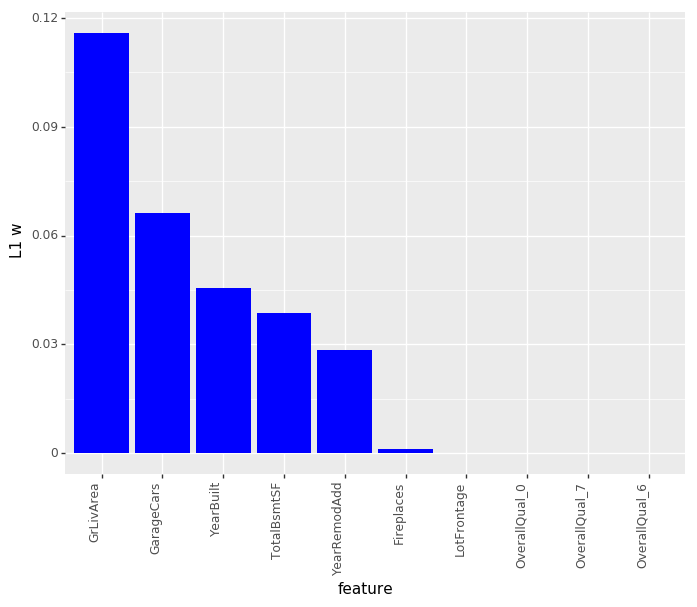

<ggplot: (297933183)>

In [236]:
l1_weights = lin_reg_l1.steps[-1][-1].coef_
df = pd.DataFrame({
    'feature': X_tr_prep.columns.values,
    'w': l1_weights,
    'w_abs': np.abs(l1_weights)})

ordered_cat = df.sort_values(by='w_abs', ascending=False)['feature']
df['feature'] = pd.Categorical(df['feature'], categories=ordered_cat, ordered=True)
df = df.sort_values(by='w_abs', ascending=False).head(10)
df['feature'].cat.remove_unused_categories(inplace=True)

(ggplot(df)
    + geom_bar(aes(x='feature', y='w'), stat='stat_identity', fill='blue')
    + labs(x='feature', y='L1 w')
    + theme(axis_text_x=element_text(angle=90, hjust=1), figure_size=(8, 6)))

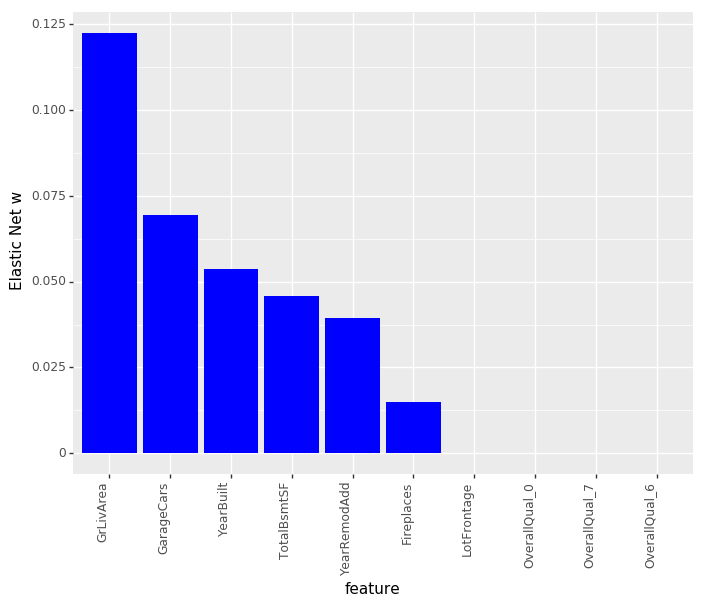

<ggplot: (-9223372036562647138)>

In [242]:
l1_l2_weights = lin_reg_l1_l2.steps[-1][-1].coef_
df = pd.DataFrame({
    'feature': X_tr_prep.columns.values,
    'w': l1_l2_weights,
    'w_abs': np.abs(l1_l2_weights)})

ordered_cat = df.sort_values(by='w_abs', ascending=False)['feature']
df['feature'] = pd.Categorical(df['feature'], categories=ordered_cat, ordered=True)
df = df.sort_values(by='w_abs', ascending=False).head(10)
df['feature'].cat.remove_unused_categories(inplace=True)

(ggplot(df)
    + geom_bar(aes(x='feature', y='w'), stat='stat_identity', fill='blue')
    + labs(x='feature', y='Elastic Net w')
    + theme(axis_text_x=element_text(angle=90, hjust=1), figure_size=(8, 6)))

GrLivArea, GarageCars, YearBuilt, TotalBsmtSF, YearRemoddAdd and Fireplaces were selected by our Lasso and Elastic Net models. Given that all these features came up in our (top 20) univariate analysis before, this indicates that for some definition of informativeness, they are the most useful for predicting house prices. We should still be careful not to immediately declare correlation for causation. To do that we should make sure that there is enough data to remove the unwanted latent effects and use our domain knowledge to make final claims.

### 3.2 Non-linear relationships, heteroskedasticity
Let's take a look at the residual vs fitted values plot next. The plot is used to detect non-linearity, unequal error variances, and outliers. Again, we are constructing it on the training dataset, hence we are only inspecting assumptions of the model, not its generalization.

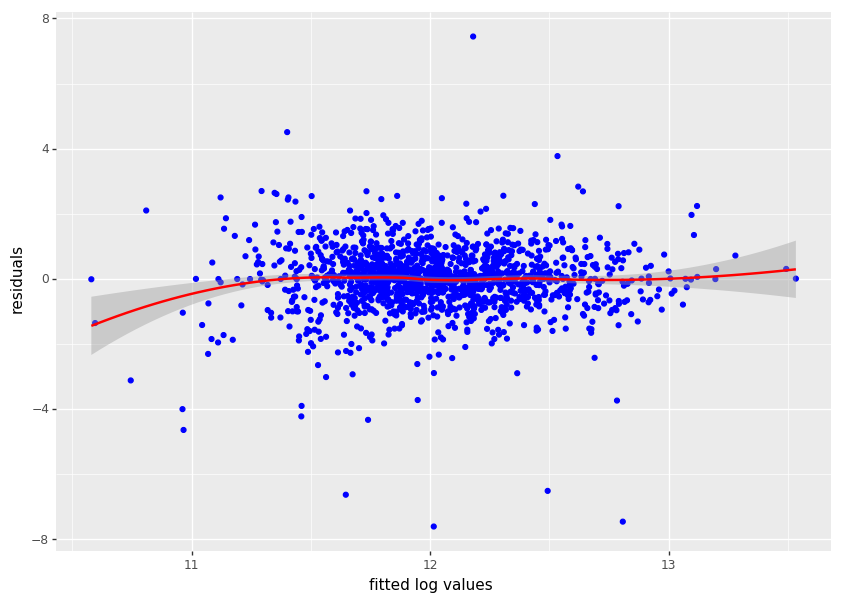

<ggplot: (297640445)>

In [206]:
y_tr_log_pred = lin_reg_l2.predict(X_tr)

residuals = y_tr_log - y_tr_log_pred
residuals = (residuals - residuals.mean()) / residuals.std()

df = pd.DataFrame({'x': y_tr_log_pred, 'y': residuals})

(ggplot(df)
    + geom_point(aes(x='x', y='y'), color='blue')
    + geom_smooth(aes(x='x', y='y'), method='loess', color='red')
    + labs(x='fitted log values', y='residuals')
    + theme(figure_size=(10, 7)))

It seems that for middle examples (fitted log values) variance is constant and relationship linear, with a few extreme exceptions that should be inspected further (could very well be outliers). There is more variability at low and high values  due to small number of examples (with really low and really large house prices) and there may bo some non-linear relationship that we are not capturing in this regions. Let's try to model simple non-linear relationships next, but we shouldn't expect much improvement (if at all) based on the residual vs fitted values plot.

In [268]:
# do fss prior to expansion to avoid blowing up feature space
remove_constant = VarianceThreshold(threshold=0)
select_k_best = SelectKBest(score_func=f_regression)
poly_expand = PolynomialFeatures(include_bias=False)

In [269]:
# L1
params_dist = {
    'selectkbest-1__k': randint(80, 200),
    'selectkbest-2__k': randint(300, 400),
    'lasso__alpha': uniform(1e-5, 1e-1)}

lin_reg_l1_poly = random_search(
    remove_constant,
    select_k_best,
    poly_expand,
    remove_constant,
    select_k_best,
    Lasso(max_iter=5000),
    params_dist=params_dist)

root mean squared log error: 0.2116 (+/- 0.05)
best params: {'lasso__alpha': 0.099593000341139867, 'selectkbest-1__k': 110, 'selectkbest-2__k': 385}


In [270]:
# L2
params_dist = {
    'selectkbest-1__k': randint(80, 200),
    'selectkbest-2__k': randint(300, 400),
    'ridge__alpha': uniform(1e-5, 1e-1)}

lin_reg_l2_poly = random_search(
    remove_constant,
    select_k_best,
    poly_expand,
    remove_constant,
    select_k_best,
    Ridge(),
    params_dist=params_dist)

root mean squared log error: 0.1836 (+/- 0.05)
best params: {'ridge__alpha': 0.0023510232647960495, 'selectkbest-1__k': 118, 'selectkbest-2__k': 394}


In [271]:
# Elastic Net
params_dist = {
    'selectkbest-1__k': randint(80, 200),
    'selectkbest-2__k': randint(300, 400),
    'elasticnet__alpha': uniform(1e-5, 1e-1),
    'elasticnet__l1_ratio': uniform()}

lin_reg_l1_l2_poly = random_search(
    remove_constant,
    select_k_best,
    poly_expand,
    remove_constant,
    select_k_best,
    ElasticNet(max_iter=5000),
    params_dist=params_dist)

root mean squared log error: 0.1650 (+/- 0.05)
best params: {'elasticnet__alpha': 0.097115420683051554, 'elasticnet__l1_ratio': 0.73612587595755707, 'selectkbest-1__k': 150, 'selectkbest-2__k': 313}


It looks like the result is not improving by polynimially expanding the feature space (this was expected based on the previous plot). We could still do a more comprehensive search for feature subset selection (leaving more features and using more agressive regularization), but won't do so because of limited resources (running on a laptop).

## 4. Next Steps
**I would take the next steps (in the order of importance) given more time.**

- **Use domain knowledge to manually engineer features is where we can gain the most predictive power so this would be the next step.**

- **Further analysis of the residual vs fitted values plot would allow us to understand which samples we make the biggest mistakes at and help us detect outliers.**

- Try PCA to transorm feature space.

- Turn to more complex ML algorithms and ensembling (even a simple average of current models should give some additional predictive power).

- We should go back to data cleaning: cross-validate ordinal and poisson feature encoding and different imputation schemes.

- When we construct a sufficiently-performing model, we should approximate out-of-the-sample performance by calculating the score on the *X_te* test set (preferably only once) and report that (not the score from the cross-validation procedure).

- If we wanted to understand the relationships between predictors and the response variable even better, we should extend our univariate feature analysis. E.g. we could use Bayesian linear regression to obtain posterior regression coefficients. As stated above, multicollinearity should be taken care of first.